# Inverse design of bimaterial LCE lattice: long strip


## Imports

In [1]:
from morphing_lattices.optimization import ForwardProblem, OptimizationProblem, scale_points, shift_points
from morphing_lattices.structure import Lattice, ControlParams
from morphing_lattices.geometry import triangular_lattice_points, triangular_lattice_connectivity
from morphing_lattices.plotting import plot_lattice, generate_animation
import pandas as pd
import jax.numpy as jnp
import numpy as np
import pickle
import os
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import experimental material params


In [2]:
exp_actuation_strain = pd.read_csv(
    '../../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv'
).drop(['Unnamed: 3'], axis=1)
exp_modulus_fine = pd.read_csv(
    '../../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv'
)
exp_modulus_fine.columns = [
    'Temp',
    'LTNI_avg_young',
    'LTNI_stdev',
    'HTNI_avg_young',
    'HTNI_stdev',
]
exp_modulus_fine.drop([0, 1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG HTNI', 'STD HTNI']
].astype(float)
LTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG LTNI', 'STD LTNI']
].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'HTNI_avg_young']
].astype(float)
LTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'LTNI_avg_young']
].astype(float)


def HTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))


def LTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))


def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

## Optimization problem

### Temperature evolution

In [3]:
sampled_temperatures = jnp.array([
    22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130
])

simulation_time = 9000.  # s
sampled_times = jnp.linspace(0, simulation_time, sampled_temperatures.shape[0])


def temperature_fn(t):
    return jnp.interp(t, sampled_times, sampled_temperatures)


def young_1_fn(t):
    return HTNI_young_fit_fine(temperature_fn(t))


def young_2_fn(t):
    return LTNI_young_fit_fine(temperature_fn(t))


def thermal_strain_1_fn(t):
    return (HTNI_stretch(temperature_fn(t))-1.)*0.8


def thermal_strain_2_fn(t):
    return (LTNI_stretch(temperature_fn(t))-1.)*0.7

### Forward problem

(<Figure size 1000x500 with 1 Axes>, <Axes: title={'center': 'Lattice'}>)

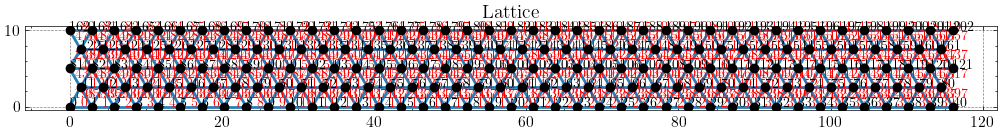

In [4]:
n1 = 40
n2 = 4
spacing = 2.9  # mm
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(
    n1=n1,
    n2=n2
)


n_points = points.shape[0]
n_bonds = connectivity.shape[0]
n_timepoints = sampled_temperatures.shape[0]

control_params = ControlParams(
    reference_points=points,  # mm
    young=jnp.ones(n_bonds),  # MPa
    area=jnp.ones(n_bonds)*(4*0.125**2),  # mm^2
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
    # NOTE: This is the initial guess for the material distribution
    phase=0.5*jnp.ones(n_bonds),#jnp.linspace(0, 1, n_bonds),  # NOTE: 0 means HTNI, 1 means LTNI
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
problem = ForwardProblem(
    lattice=lattice,
    simulation_time=simulation_time,
    n_timepoints=n_timepoints,
)
problem.setup(
    young_1_fn=young_1_fn,
    young_2_fn=young_2_fn,
    thermal_strain_1_fn=thermal_strain_1_fn,
    thermal_strain_2_fn=thermal_strain_2_fn,
    temperature_fn = temperature_fn,
)

plot_lattice(lattice=lattice, figsize=(10, 5), annotate=True)

### Optimization


#### Target points

In [5]:
# Select the centerline points
target_points_ids = jnp.arange(n2//2*n1+1, (n2//2+1)*n1+2)

# optimization_name = 'W_M'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     -jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
# ]).T


# optimization_name = 'W_U'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     -jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*3
# ]).T

# optimization_name = 'U_W'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*3
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     -jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5)
# ]).T

# optimization_name = 'U_M'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*3
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.abs(jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*7)
# ]).T


# sine wave -> U
# optimization_name = 'snake_U'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*2
# ]).T


# U -> sine wave
# optimization_name = 'U_snake'
# target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     (jnp.linspace(-jnp.pi, jnp.pi, target_points_ids.shape[0])**2)*2
# ]).T

# target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
#     jnp.linspace(1, -1, target_points_ids.shape[0])*20,
#     jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*5
# ]).T


# # Sine -> sine
optimization_name = 'snake'
target1_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
    jnp.linspace(1, -1, target_points_ids.shape[0])*20,
    jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*10
]).T

target2_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
    jnp.linspace(1, -1, target_points_ids.shape[0])*20,
    -jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*10
]).T



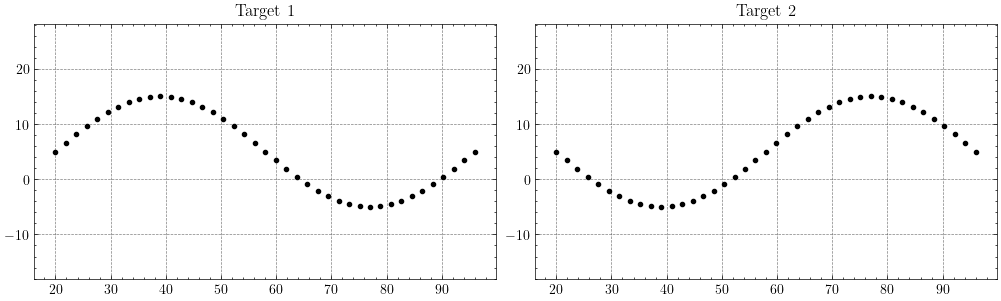

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
ax1.plot(target1_points[:, 0], target1_points[:, 1],
         'o', color='k', markersize=3)
ax2.plot(target2_points[:, 0], target2_points[:, 1],
         'o', color='k', markersize=3)
ax1.set_title('Target 1')
ax2.set_title('Target 2')
ax1.axis('equal')
ax2.axis('equal')

save_opt_information = True
if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shapes.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

### Run the optimization with various weights

In [7]:
target1_temperature = 70. # Celcius
target2_temperature = 130. # Celcius

weight_array = jnp.array([jnp.linspace(1, 0, 21), jnp.linspace(0, 1, 21)])

for i in jnp.arange(weight_array.shape[1]):
    
    optimization = OptimizationProblem(
        forward_problem=problem,
        target1_points=target1_points,
        target2_points=target2_points,
        target_points_ids=target_points_ids,
        target1_temperature=target1_temperature,
        target2_temperature=target2_temperature,
        weights=weight_array[:, i]
    )

    optimization.run_optimization_nlopt(
        n_iterations=50,
        # max_time=60,
        lower_bound=0.,
        upper_bound=1.,
    )

    dir_path = f"../out/inverse_design/n1_{n1}_n2_{n2}/{optimization_name}/w1_{weight_array[0, i]:.2f}_w2_{weight_array[1, i]:.2f}"
    out_path = Path(f"{str(dir_path)}/optimization_data.pickle")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist

    optimization_data = optimization.to_data()

    with open(out_path, 'wb') as f:
        pickle.dump(optimization_data, f)


Iteration: 1
Objective = 0.5711682084991607
Iteration: 2
Objective = 0.5710706987806963
Iteration: 3
Objective = 0.5701093104640773
Iteration: 4
Objective = 0.5580637402521983
Iteration: 5
Objective = 0.4603105949557636
Iteration: 6
Objective = 0.39844559217980263
Iteration: 7
Objective = 0.39711874024686966
Iteration: 8
Objective = 0.39649883532319014
Iteration: 9
Objective = 0.39586477881467463
Iteration: 10
Objective = 0.39463595523253864
Iteration: 11
Objective = 0.3934884528487843
Iteration: 12
Objective = 0.3932017385638985
Iteration: 13
Objective = 0.393180506338909
Iteration: 14
Objective = 0.392359318697435
Iteration: 15
Objective = 0.3916785494196274
Iteration: 16
Objective = 0.3941298658604819
Iteration: 17
Objective = 0.3926693120226899
Iteration: 18
Objective = 0.39165561205964683
Iteration: 19
Objective = 0.39158869921717154
Iteration: 20
Objective = 0.3915429613556242
Iteration: 21
Objective = 0.39151278303797876
Iteration: 22
Objective = 0.3914571423370772
Iteration: 23

### Plot the optimized lattices for each set of weights

In [ ]:
for i in jnp.arange(weight_array.shape[1]):
    dir_path = f"../out/inverse_design/n1_{n1}_n2_{n2}/{optimization_name}/w1_{weight_array[0, i]:.2f}_w2_{weight_array[1, i]:.2f}"

    with open(os.path.join(dir_path, 'optimization_data.pickle'), 'rb') as f:
        loaded_optimization_data = pickle.load(f)

    # Plot the objective value
    plt.figure(figsize=[5,3])
    plt.plot(loaded_optimization_data.objective_values, color='k', marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Objective Value Evolution')
    out_path = Path(f"{dir_path}/objective_value_evolution.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)
    plt.close()

    plot_lattice(
        lattice=lattice,
        title='Target Shape 1',
        displacement=loaded_optimization_data.best_response[optimization.target1_temperature_timepoint, 0],
        bond_values=loaded_optimization_data.best_control_params.phase,
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        legend_label="Phase",
    )
    out_path = Path(f"{dir_path}/target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)
    plt.close()

    plot_lattice(
        lattice=lattice,
        title='Target Shape 2',
        displacement=loaded_optimization_data.best_response[optimization.target2_temperature_timepoint, 0],
        bond_values=loaded_optimization_data.best_control_params.phase,
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        legend_label="Phase",
    )
    out_path = Path(f"{dir_path}/target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)
    plt.close()

    # Solve the forward problem
    phase_threshold = 0.5
    discrete_phases = jnp.where(loaded_optimization_data.best_control_params.phase > phase_threshold, 1, 0)
    discrete_phase_solution, discrete_control_params = problem.solve(discrete_phases)

    # Plot and save the deformed lattice
    LTNI_bond_indices = jnp.where(discrete_phases == 1)[0]
    HTNI_bond_indices = jnp.where(discrete_phases == 0)[0]

    plot_lattice(
        lattice=lattice,
        title='Target Shape 1',
        displacement=discrete_phase_solution[optimization.target1_temperature_timepoint, 0],
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        HTNI_bond_indices=HTNI_bond_indices,
        LTNI_bond_indices=LTNI_bond_indices,
    )
    out_path = Path(f"{dir_path}/LCE_labeled_target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)
    plt.close()

    plot_lattice(
        lattice=lattice,
        title='Target Shape 2',
        displacement=discrete_phase_solution[optimization.target2_temperature_timepoint, 0],
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        HTNI_bond_indices=HTNI_bond_indices,
        LTNI_bond_indices=LTNI_bond_indices,
    )
    out_path = Path(f"{dir_path}/LCE_labeled_target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)
    plt.close()

    # Generate the animation
    generate_animation(
        lattice=lattice, 
        solution=discrete_phase_solution, 
        out_filename=f'{dir_path}/discrete_animation', 
        frame_range=jnp.arange(n_timepoints), 
        xlim=[-5, 120],
        ylim=[-15, 20],
        figsize=[10, 5], 
        x_label='x [mm]',
        y_label='y [mm]',
        title=f'{optimization_name} Discrete Optimized Geometry Evolution')
    plt.close()

0 /21
1 /21
2 /21
3 /21
4 /21
5 /21
6 /21
7 /21
8 /21
9 /21
10 /21
11 /21
12 /21
13 /21
14 /21
15 /21
16 /21
17 /21
18 /21
19 /21
20 /21


### Run optimization


In [7]:
target1_temperature = 70. # Celcius
target2_temperature = 130. # Celcius

optimization = OptimizationProblem(
    forward_problem=problem,
    target1_points=target1_points,
    target2_points=target2_points,
    target_points_ids=target_points_ids,
    target1_temperature=target1_temperature,
    target2_temperature=target2_temperature,
)

In [8]:
optimization.run_optimization_nlopt(
    n_iterations=50,
    # max_time=60,
    lower_bound=0.,
    upper_bound=1.,
)

Iteration: 1
Objective = 0.5704207512816866
Iteration: 2
Objective = 0.5703615951072745
Iteration: 3
Objective = 0.5697770265292359
Iteration: 4
Objective = 0.5622900774028017
Iteration: 5
Objective = 0.4918982880174556
Iteration: 6
Objective = 0.4209371826743166
Iteration: 7
Objective = 0.42359973496352715
Iteration: 8
Objective = 0.42225614983393883
Iteration: 9
Objective = 0.4202366161849458
Iteration: 10
Objective = 0.41938507589389284
Iteration: 11
Objective = 0.4189211501193464
Iteration: 12
Objective = 0.41881987320362524
Iteration: 13
Objective = 0.41868342868113784
Iteration: 14
Objective = 0.41823252453690146
Iteration: 15
Objective = 0.4181926325960076
Iteration: 16
Objective = 0.41779697659069354
Iteration: 17
Objective = 0.4176368285699187
Iteration: 18
Objective = 0.4175951180361869
Iteration: 19
Objective = 0.41751370402922483
Iteration: 20
Objective = 0.41726027197154747
Iteration: 21
Objective = 0.417934271985554
Iteration: 22
Objective = 0.41719190926184613
Iteration:

### Plot the objective values

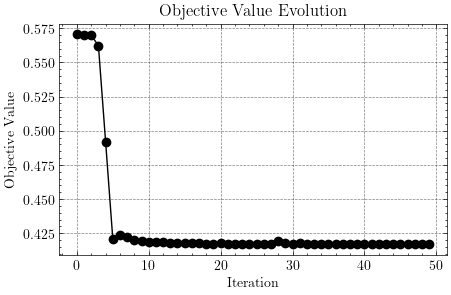

In [9]:
plt.figure(figsize=[5,3])
plt.plot(optimization.objective_values, color='k', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value Evolution');

if save_opt_information:
    out_path = Path(f"{optimization_name}/objective_value_evolution.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

### Plot the deformed shapes (continuous)

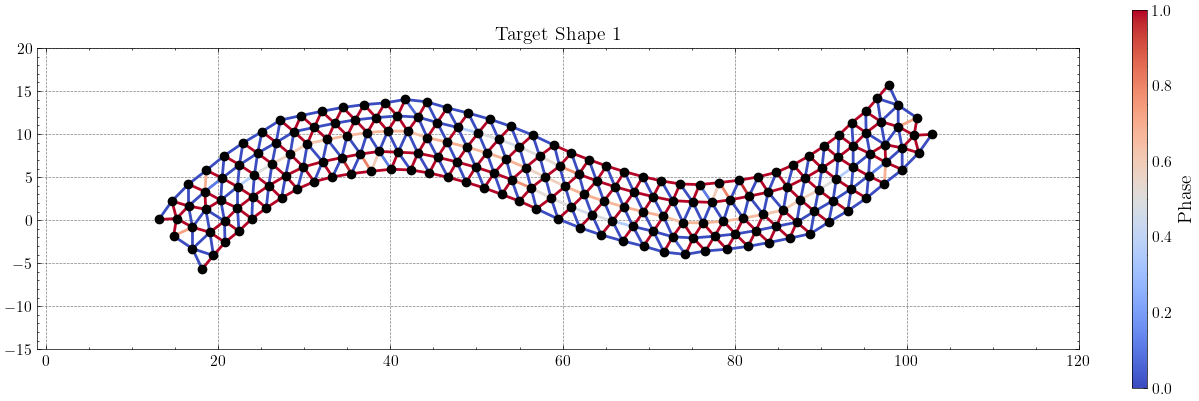

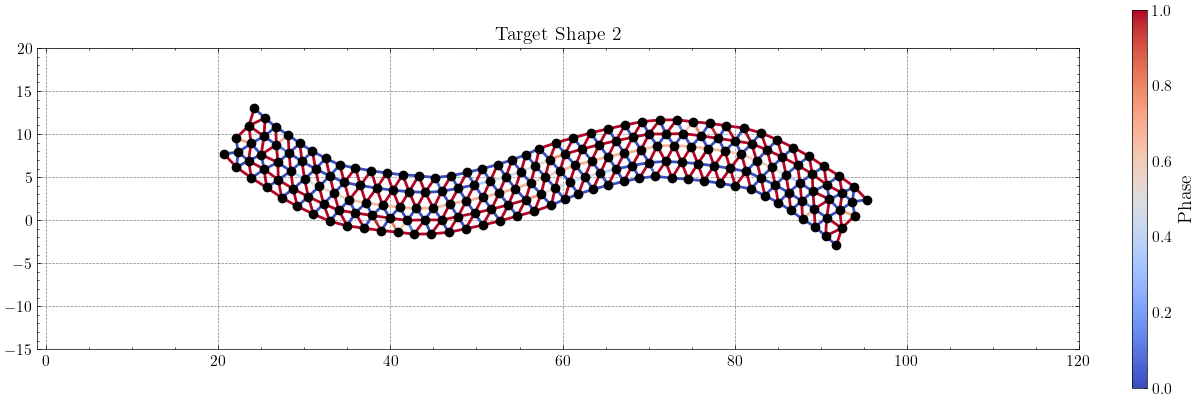

In [10]:
plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=optimization.best_response[optimization.target1_temperature_timepoint, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=optimization.best_response[optimization.target2_temperature_timepoint, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

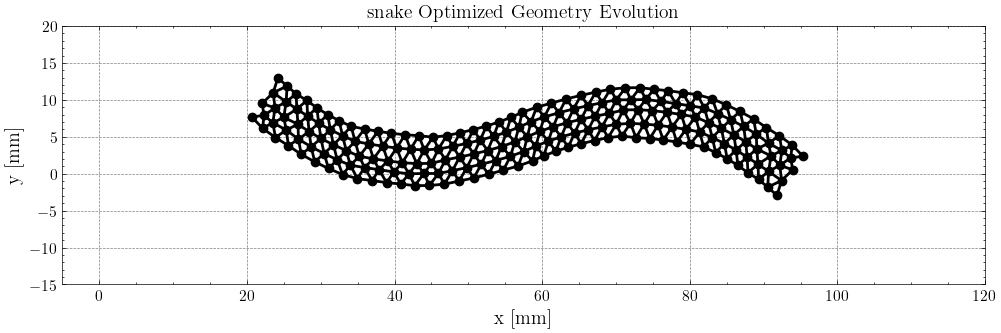

In [11]:
generate_animation(
    lattice=lattice, 
    solution=optimization.best_response, 
    out_filename=f'{optimization_name}/animation', 
    frame_range=jnp.arange(23), 
    xlim=[-5, 120],
    ylim=[-15, 20],
    figsize=[10, 5], 
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Optimized Geometry Evolution')

### Impose Discrete Phase Values Corresponding to HTNI and LTNI LCE

In [12]:
phase_threshold = 0.5
discrete_phases = jnp.where(optimization.best_control_params.phase > phase_threshold, 1, 0)

discrete_phase_solution, discrete_control_params = problem.solve(discrete_phases)

C:\Users\annwa\Desktop\Research\Structure_Optimization\morphing-lattices\morphing_lattices\plotting.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)


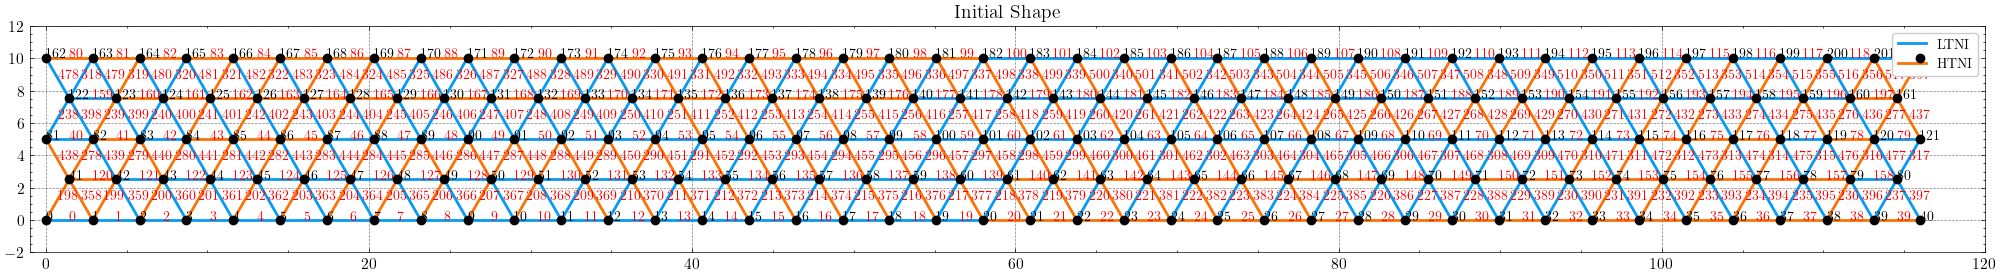

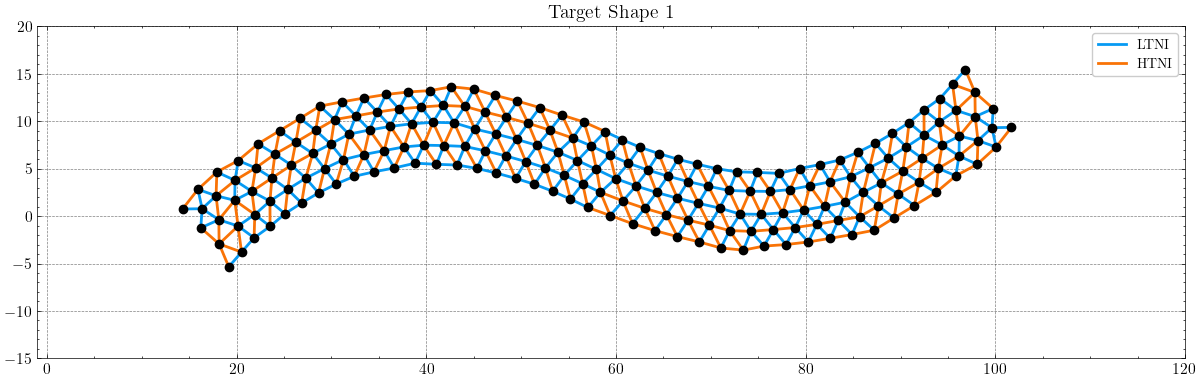

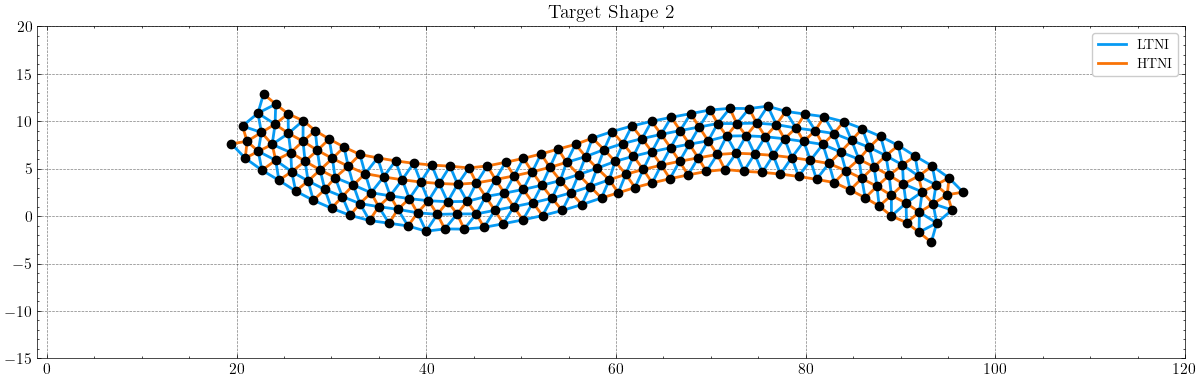

In [21]:
LTNI_bond_indices = jnp.where(discrete_phases == 1)[0]
HTNI_bond_indices = jnp.where(discrete_phases == 0)[0]

plot_lattice(
    lattice=lattice,
    title='Initial Shape',
    displacement=discrete_phase_solution[0, 0],
    figsize=(20, 5),
    xlim=(-1, 120),
    ylim=(-2, 12),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
    annotate=True
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_initial_shape_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=discrete_phase_solution[optimization.target1_temperature_timepoint, 0],
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=discrete_phase_solution[optimization.target2_temperature_timepoint, 0],
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

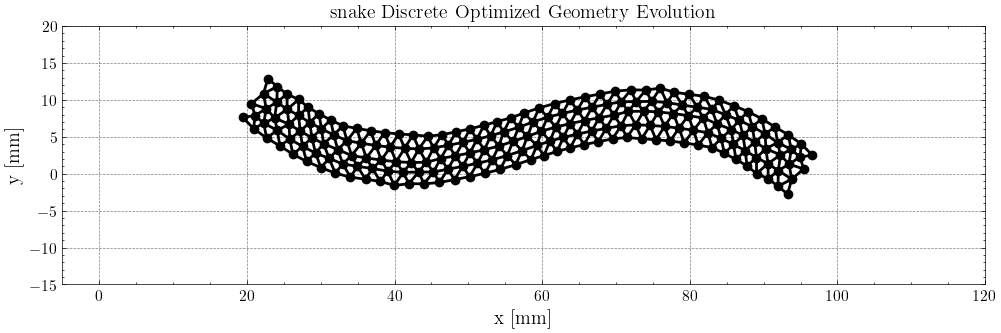

In [22]:
generate_animation(
    lattice=lattice, 
    solution=discrete_phase_solution, 
    out_filename=f'{optimization_name}/discrete_animation', 
    frame_range=jnp.arange(n_timepoints), 
    xlim=[-5, 120],
    ylim=[-15, 20],
    figsize=[10, 5], 
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Discrete Optimized Geometry Evolution')

### Save 3D printing data

In [23]:
out_path = Path(
    f"../../exp/inversely_designed_lattices/{optimization_name}/3d_printing_data.npz"
)
out_path.parent.mkdir(parents=True, exist_ok=True)
np.savez(
    out_path,
    points=lattice.control_params.reference_points,
    connectivity=lattice.connectivity,
    phase=discrete_phases,
)

### Final Response vs Target Points

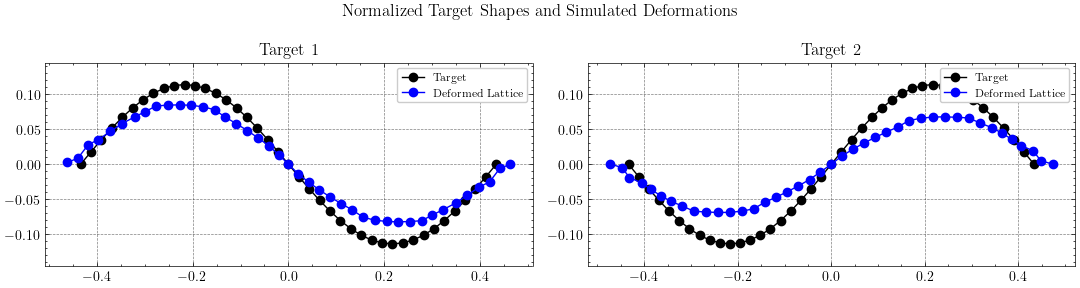

In [24]:
deformed_target1_points = discrete_phase_solution[optimization.target1_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]
deformed_target2_points = discrete_phase_solution[optimization.target2_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]


# Scale and shift target1_points, target2_points, and the deformed lattice points
transformed_deformed_target1_points = shift_points(scale_points(deformed_target1_points))
transformed_deformed_target2_points = shift_points(scale_points(deformed_target2_points))

transformed_target1_points = shift_points(scale_points(target1_points))
transformed_target2_points = shift_points(scale_points(target2_points))

def rotation_matrix(angle):
    """
    docstring
    """

    return jnp.array([[jnp.cos(angle), -jnp.sin(angle)],
                      [jnp.sin(angle), jnp.cos(angle)]])

if optimization_name == 'snake':
    # Rotate deformed points
    theta1 = jnp.arctan(-transformed_deformed_target1_points[-1, 1] / transformed_deformed_target1_points[-1, 0])
    theta2 = jnp.arctan(-transformed_deformed_target2_points[-1, 1] / transformed_deformed_target2_points[-1, 0])
    transformed_deformed_target1_points = jnp.matmul(rotation_matrix(theta1),transformed_deformed_target1_points.T).T
    transformed_deformed_target2_points = jnp.matmul(rotation_matrix(theta2),transformed_deformed_target2_points.T).T

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[11,3])
ax1.plot(transformed_target1_points[:, 0], transformed_target1_points[:, 1], 'ko-', label='Target')
ax1.plot(transformed_deformed_target1_points[:, 0], transformed_deformed_target1_points[:, 1], 'bo-', label='Deformed Lattice')
ax1.legend(fontsize=8, loc='upper right')
ax1.set_title('Target 1')
ax1.set_ylim([ax1.get_ylim()[0]-0.02, ax1.get_ylim()[1]+0.02])

ax2.plot(transformed_target2_points[:, 0], transformed_target2_points[:, 1], 'ko-', label='Target')
ax2.plot(transformed_deformed_target2_points[:, 0], transformed_deformed_target2_points[:, 1], 'bo-', label='Deformed Lattice')
ax2.legend(fontsize=8, loc='upper right')
ax2.set_title('Target 2')
ax2.set_ylim([ax2.get_ylim()[0]-0.02, ax2.get_ylim()[1]+0.02])

plt.suptitle('Normalized Target Shapes and Simulated Deformations')
plt.tight_layout()

if save_opt_information:
    out_path = Path(f"{optimization_name}/normalized_target_and_deformed_shapes.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

### Compare intuitive design and optimized design of "snake"

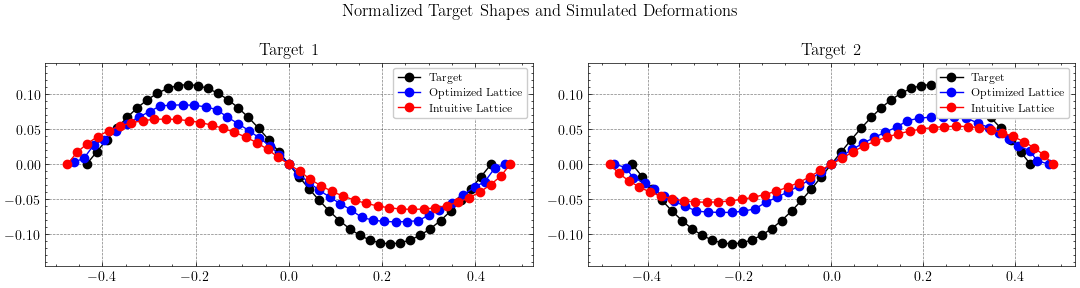

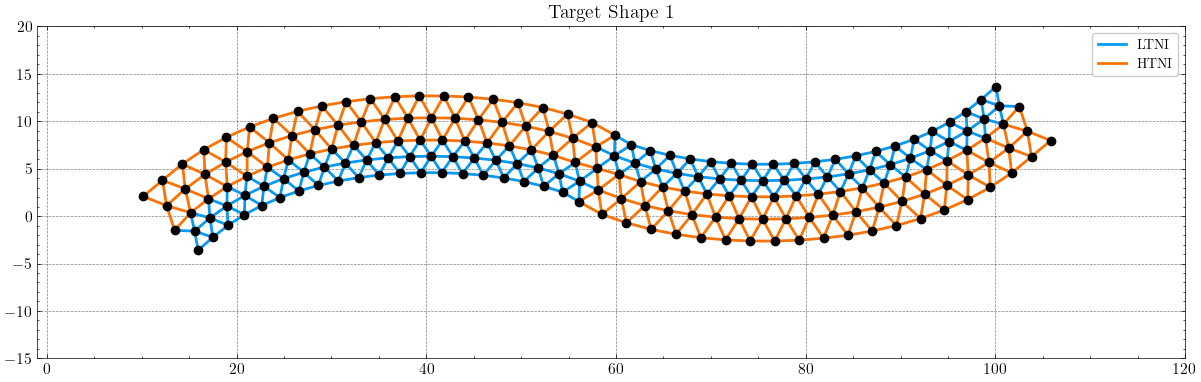

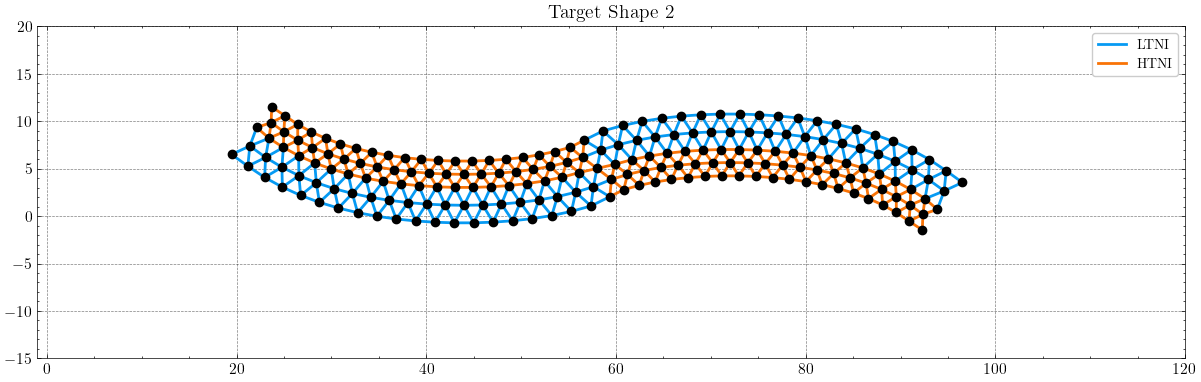

In [25]:
# This is for n1 = 40, n2 = 4

if optimization_name == 'snake':
    bilayer_known_phase_LTNI_idxs = jnp.concatenate([jnp.arange(20), jnp.arange(120, 140), jnp.arange(198, 218), jnp.arange(358, 378), jnp.arange(278, 298), jnp.arange(438, 458),
                                                    jnp.arange(100, 120), jnp.arange(178, 198), jnp.arange(338, 358), jnp.arange(498, 518), jnp.arange(418, 438), jnp.arange(258, 278)])
    bilayer_known_phase_HTNI_idxs = jnp.delete(jnp.arange(n_bonds), bilayer_known_phase_LTNI_idxs)
    bilayer_known_phase = jnp.zeros(n_bonds)
    bilayer_known_phase = bilayer_known_phase.at[bilayer_known_phase_LTNI_idxs].set(1.)

    known_bilayer_design_sol, _ = problem.solve(bilayer_known_phase)

    deformed_target1_points_intuitive = known_bilayer_design_sol[optimization.target1_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]
    deformed_target2_points_intuitive = known_bilayer_design_sol[optimization.target2_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]

    transformed_deformed_target1_intuitive_points = shift_points(scale_points(deformed_target1_points_intuitive))
    transformed_deformed_target2_intuitive_points = shift_points(scale_points(deformed_target2_points_intuitive))

    theta1_intuitive = jnp.arctan(-transformed_deformed_target1_intuitive_points[-1, 1] / transformed_deformed_target1_intuitive_points[-1, 0])
    theta2_intuitive = jnp.arctan(-transformed_deformed_target2_intuitive_points[-1, 1] / transformed_deformed_target2_intuitive_points[-1, 0])
    transformed_deformed_target1_intuitive_points = jnp.matmul(rotation_matrix(theta1_intuitive),transformed_deformed_target1_intuitive_points.T).T
    transformed_deformed_target2_intuitive_points = jnp.matmul(rotation_matrix(theta2_intuitive),transformed_deformed_target2_intuitive_points.T).T

    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[11,3])
    ax1.plot(transformed_target1_points[:, 0], transformed_target1_points[:, 1], 'ko-', label='Target')
    ax1.plot(transformed_deformed_target1_points[:, 0], transformed_deformed_target1_points[:, 1], 'bo-', label='Optimized Lattice')
    ax1.plot(transformed_deformed_target1_intuitive_points[:, 0], transformed_deformed_target1_intuitive_points[:, 1], 'ro-', label='Intuitive Lattice')
    ax1.legend(fontsize=8, loc='upper right')
    ax1.set_title('Target 1')
    ax1.set_ylim([ax1.get_ylim()[0]-0.02, ax1.get_ylim()[1]+0.02])

    ax2.plot(transformed_target2_points[:, 0], transformed_target2_points[:, 1], 'ko-', label='Target')
    ax2.plot(transformed_deformed_target2_points[:, 0], transformed_deformed_target2_points[:, 1], 'bo-', label='Optimized Lattice')
    ax2.plot(transformed_deformed_target2_intuitive_points[:, 0], transformed_deformed_target2_intuitive_points[:, 1], 'ro-', label='Intuitive Lattice')
    ax2.legend(fontsize=8, loc='upper right')
    ax2.set_title('Target 2')
    ax2.set_ylim([ax2.get_ylim()[0]-0.02, ax2.get_ylim()[1]+0.02])

    plt.suptitle('Normalized Target Shapes and Simulated Deformations')
    plt.tight_layout()

    if save_opt_information:
        out_path = Path(f"bilayer_initial_guess_snake/normalized_target_and_optimized_and_guessed_shapes.png")
        out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        plt.savefig(str(out_path), dpi=200)

    plot_lattice(
        lattice=lattice,
        title='Target Shape 1',
        displacement=known_bilayer_design_sol[optimization.target1_temperature_timepoint, 0],
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        HTNI_bond_indices=bilayer_known_phase_HTNI_idxs,
        LTNI_bond_indices=bilayer_known_phase_LTNI_idxs,
    )

    if save_opt_information:
        out_path = Path(f"bilayer_initial_guess_snake/LCE_labeled_intuitive_target_shape1_phase_vals.png")
        out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        plt.savefig(str(out_path), dpi=200)

    plot_lattice(
        lattice=lattice,
        title='Target Shape 2',
        displacement=known_bilayer_design_sol[optimization.target2_temperature_timepoint, 0],
        figsize=(12, 4),
        xlim=(-1, 120),
        ylim=(-15, 20),
        HTNI_bond_indices=bilayer_known_phase_HTNI_idxs,
        LTNI_bond_indices=bilayer_known_phase_LTNI_idxs,
    )

    if save_opt_information:
        out_path = Path(f"bilayer_initial_guess_snake/LCE_labeled_intuitive_target_shape2_phase_vals.png")
        out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        plt.savefig(str(out_path), dpi=200)